In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funcs.models import model_ND
from funcs.fitting import loss
from scipy.optimize import minimize

## Heat input function

In [2]:
func_Q_in = lambda x: (1 + 0.5*np.sin(2*np.pi*x/(3600*12))) #

We are able to recover the desired heat capacity, thermal conductivity and initial temperature even with pretty bad intial guesses. However, need to ensure intial guesses are at least on the right order of magnitude.

## 2 Segments

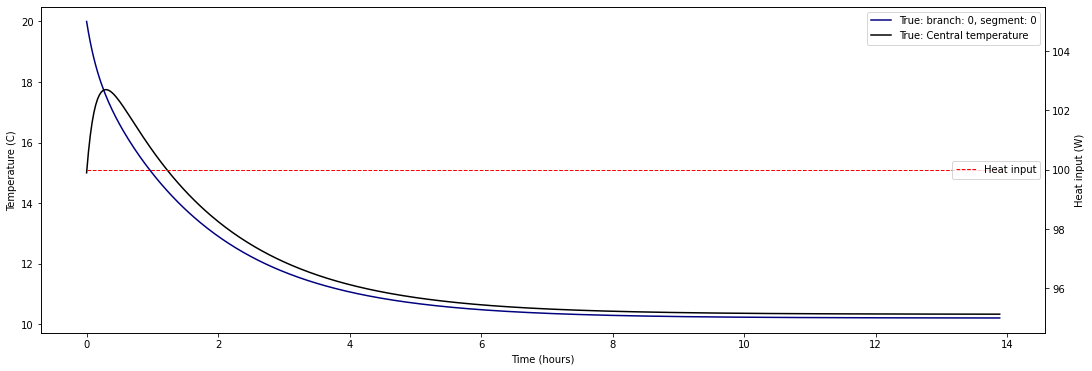

In [3]:
k = [800.0, 500.0]
c = [6e5, 2.5e6]
T = [15.0, 20.0]
iterations = 500

true_params = np.array([*k, *c, *T])
T_out = np.full(iterations, 10)
heatinput = np.full(iterations+1, 100)
# Initialise class with system parameters
sys_nd = model_ND('True', k, c, T, T_out, heatinput)

# Run simulation.
times = np.linspace(0, 5e4, iterations+1)
Ts_true = sys_nd.run(times=times)
fig, ax = sys_nd.plot()

### Note on loss function
> The losses between model and true temperature of nodes are combined into a total loss, and this total loss is minimised. We might have better success by estimating parameters in individual segments first?

> We might be able to use the max rate of change of temperature of a particular node to provide initial guesses/bounds on thermal conductivity

In [4]:
# Initial guesses for scipy.optimize.minimize
k0 = [900.0, 400.0]
c0 = [7e5, 1e6]
T0 = [16.0, 19.0]
initial_params = np.array([*k0, *c0, *T0])

# Testing different loss functions

#### Mean square error

$$ L_{\rm MSE} = \frac{1}{N} \sum (T_{\rm true} - T_{\rm est})^2 $$ 

In [5]:
loss(initial_params, 'mse', times, Ts_true, T_out, heatinput)

0.5012864650739197

	Initial			Estimated		Actual
k1:	900.00000		895.58082		800.00000
k2:	400.00000		292.01039		500.00000
c1:	700000.00000		700000.03155		600000.00000
c2:	1000000.00000		1000000.02770		2500000.00000
T1:	16.00000		15.60726		15.00000
T2:	19.00000		21.65971		20.00000
______________________________________________________
Percentage error:
k1:		11.95%		k2:		41.60%
c1:		16.67%		c2:		60.00%
T1_initial:	4.05%		T2_initial:	8.30%


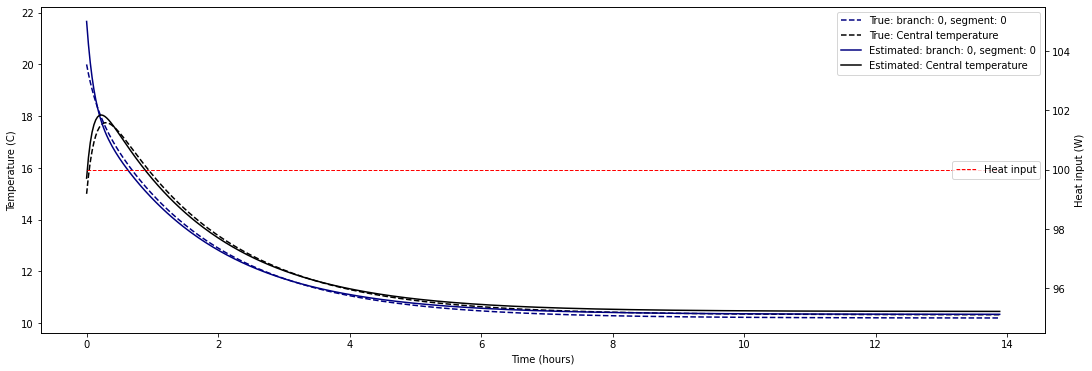

In [6]:
result = minimize(loss, x0=initial_params, tol=1e-3, args=('mse', times, Ts_true, T_out, heatinput), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
Ts_est = sys_est.run(times=times)

fig, ax = sys_nd.plot(ls='--')
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

#### Mean absolute deviation

$$ L_{\rm MSE} = \frac{1}{N} \sum |T_{\rm true} - T_{\rm est}| $$ 

	Initial			Estimated		Actual
k1:	900.00000		896.24245		800.00000
k2:	400.00000		302.30174		500.00000
c1:	700000.00000		700000.02559		600000.00000
c2:	1000000.00000		1000000.01876		2500000.00000
T1:	16.00000		14.99991		15.00000
T2:	19.00000		23.00068		20.00000
______________________________________________________
Percentage error:
k1:		12.03%		k2:		39.54%
c1:		16.67%		c2:		60.00%
T1_initial:	0.00%		T2_initial:	15.00%


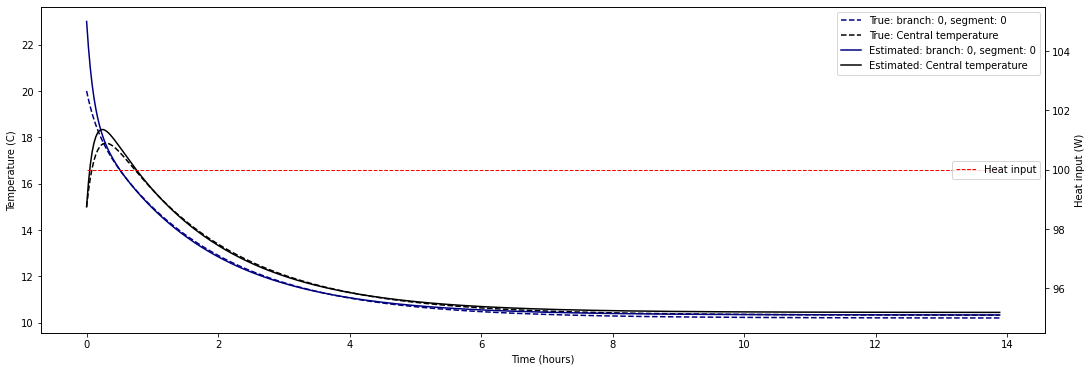

In [7]:
result = minimize(loss, x0=initial_params, args=('mad', times, Ts_true, T_out, heatinput), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated', k_est, c_est, T_est, T_out, heatinput)
Ts_est = sys_est.run(times=times)

fig, ax = sys_nd.plot(ls='--')
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

#### Sum of squares

$$ L_{\rm MSE} = \sum (T_{\rm true} - T_{\rm est})^2 $$ 

	Initial			Estimated		Actual
k1:	900.00000		906.34777		800.00000
k2:	400.00000		291.15393		500.00000
c1:	700000.00000		700000.10453		600000.00000
c2:	1000000.00000		1000000.45856		2500000.00000
T1:	16.00000		15.56398		15.00000
T2:	19.00000		21.65762		20.00000
______________________________________________________
Percentage error:
k1:		13.29%		k2:		41.77%
c1:		16.67%		c2:		60.00%
T1_initial:	3.76%		T2_initial:	8.29%


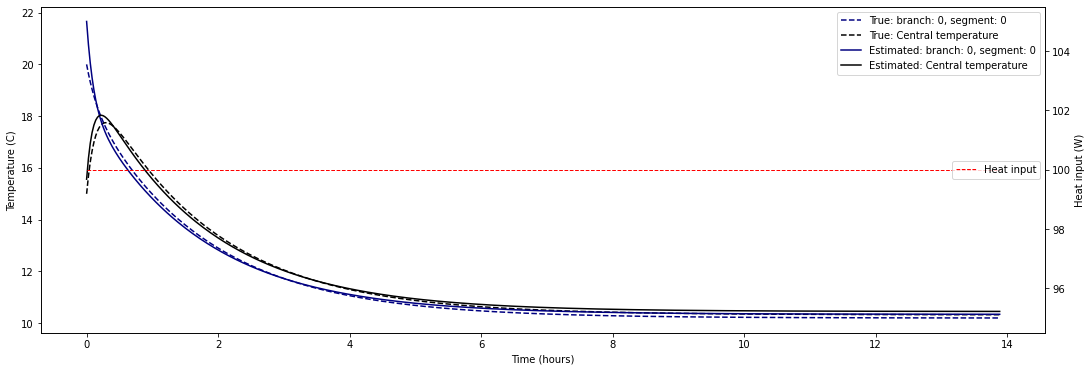

In [8]:
result = minimize(loss, x0=initial_params, args=('sse', times, Ts_true, T_out, heatinput), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated', k_est, c_est, T_est, T_out, heatinput)
Ts_est = sys_est.run(times=times)


fig, ax = sys_nd.plot(ls='--')
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

#### Least absolute error

$$ L_{\rm MSE} = \sum |T_{\rm true} - T_{\rm est}| $$ 

	Initial			Estimated		Actual
k1:	900.00000		896.28916		800.00000
k2:	400.00000		302.31372		500.00000
c1:	700000.00000		700000.02947		600000.00000
c2:	1000000.00000		1000000.02158		2500000.00000
T1:	16.00000		14.99999		15.00000
T2:	19.00000		23.00086		20.00000
______________________________________________________
Percentage error:
k1:		12.04%		k2:		39.54%
c1:		16.67%		c2:		60.00%
T1_initial:	0.00%		T2_initial:	15.00%


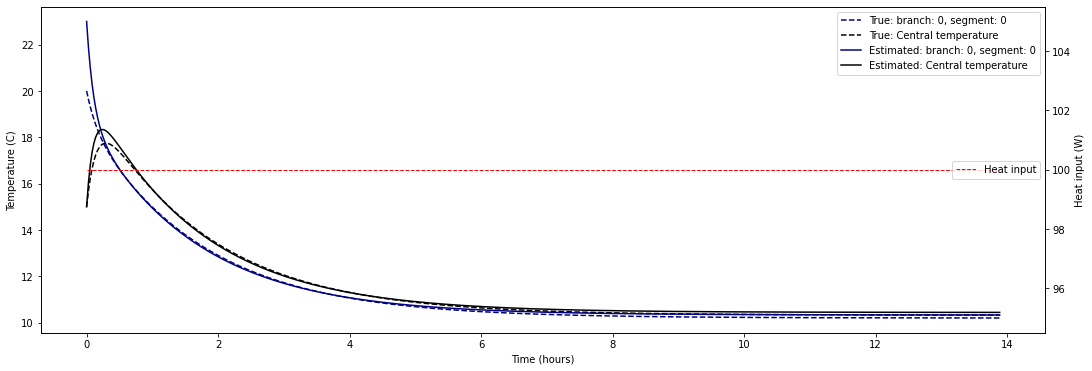

In [9]:
result = minimize(loss, x0=initial_params, args=('lae', times, Ts_true, T_out, heatinput), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated', k_est, c_est, T_est, T_out, heatinput)
Ts_est = sys_est.run(times=times)


fig, ax = sys_nd.plot(ls='--')
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

# Evaluating training
### Tolerance

In [10]:
from time import time
frac_errors = []
losses = []
duration = []
tolerances = [1e-3, 1e-5, 1e-10, 1e-13, 1e-15, 1e-18, 1e-20, 1e-23]
for tolerance in tolerances:
    start = time()
    result = minimize(loss, x0=initial_params, tol=tolerance, args=('mse', times, Ts_true, T_out, heatinput), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
    end = time()
    
    k_est, c_est, T_est = result['x'].reshape((3,2))

#     Lines below not needed
#     sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
#     Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)
    
    frac_error = abs((result['x'] - true_params)/true_params * 100)
    
    duration.append((end-start)/60.0)
    losses.append(loss(result['x'], 'mse', times, Ts_true, T_out, heatinput))
    frac_errors.append(frac_error)

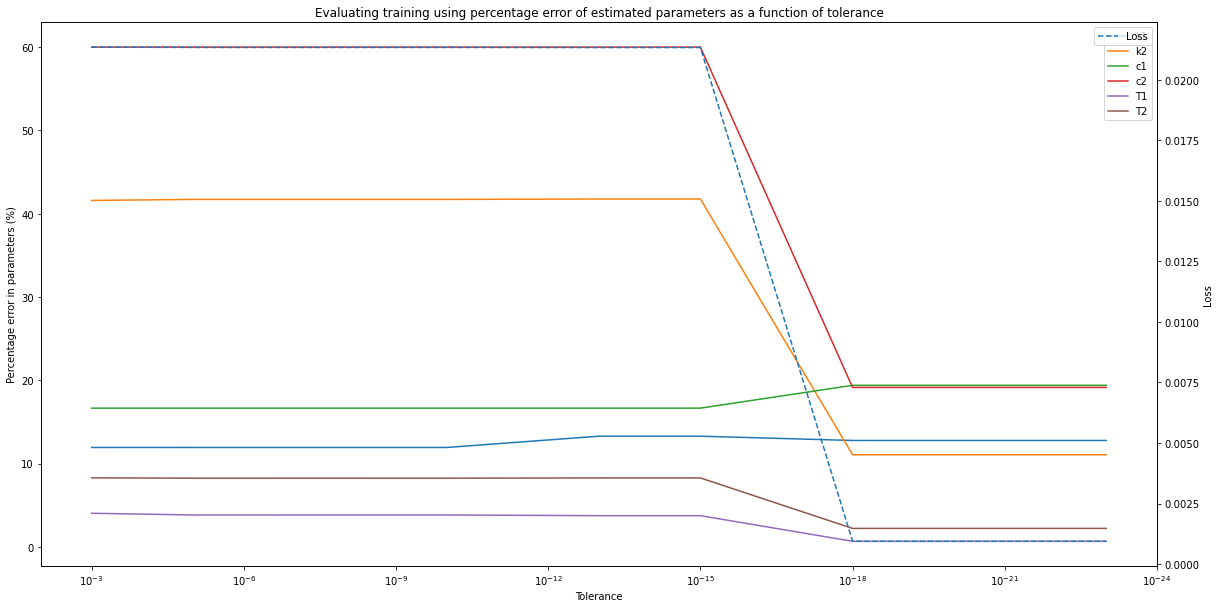

In [11]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(tolerances, np.array(frac_errors))
ax2 = ax.twinx()
ax2.plot(tolerances, losses, label='Loss', ls='--')
ax.set(xscale='log', xlabel='Tolerance', ylabel='Percentage error in parameters (%)', title='Evaluating training using percentage error of estimated parameters as a function of tolerance')
ax2.set(ylabel='Loss')
# ax.title()
ax.legend(['k1','k2','c1','c2','T1','T2'])
ax2.legend()
ax.invert_xaxis()

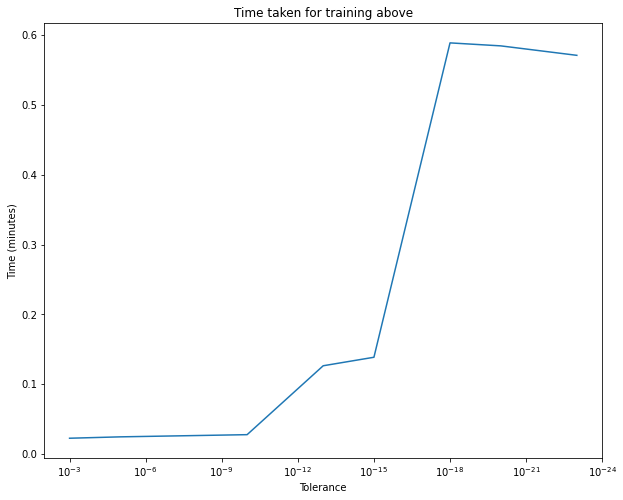

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(tolerances, duration)
ax.set(xscale='log', xlabel='Tolerance', ylabel='Time (minutes)', title='Time taken for training above')
ax.invert_xaxis()

### Max iterations

In [13]:
from time import time
frac_errors = []
losses = []
duration = []
max_iters = [1e2, 1e3, 1e4, 1e5, 1e6]
args = ('mse', times, Ts_true, T_out, heatinput)
for max_iter in max_iters:
    start = time()
    result = minimize(loss, x0=initial_params, options={'maxiter':max_iter}, args=args, bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
    end = time()
    
    k_est, c_est, T_est = result['x'].reshape((3,2))

#     Lines below not needed
#     sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
#     Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)
    
    frac_error = abs((result['x'] - true_params)/true_params * 100)
    
    duration.append((end-start)/60.0)
    losses.append(loss(result['x'], *args))
    frac_errors.append(frac_error)

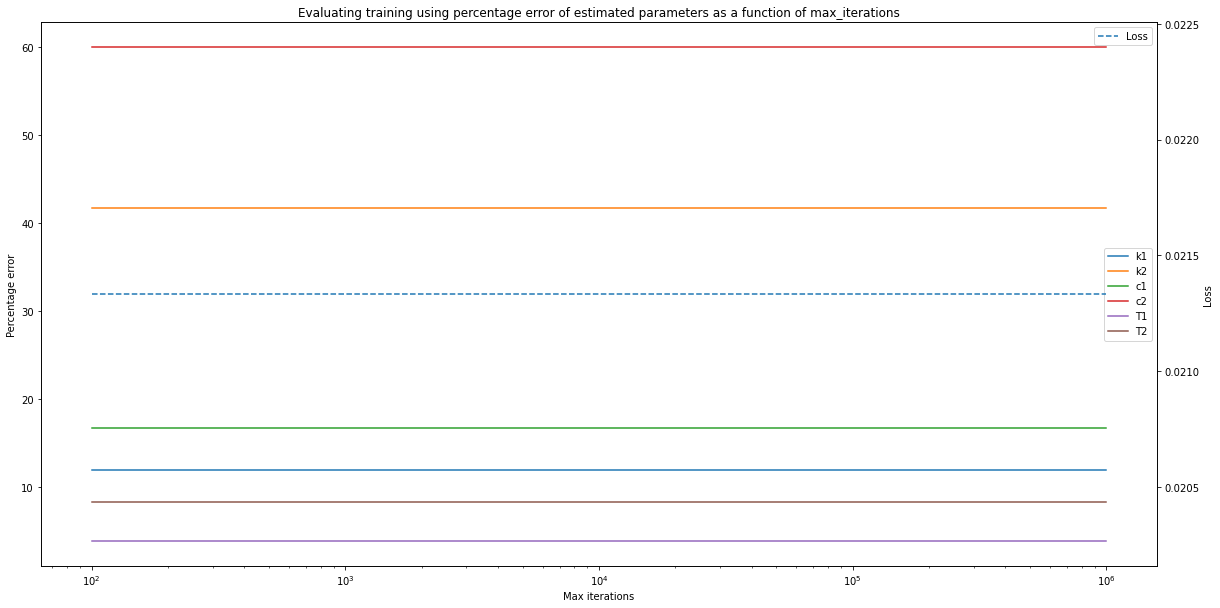

In [14]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(max_iters, np.array(frac_errors))
ax2 = ax.twinx()
ax2.plot(max_iters, losses, label='Loss', ls='--')
ax.set(xscale='log', xlabel='Max iterations', ylabel='Percentage error', title='Evaluating training using percentage error of estimated parameters as a function of max_iterations')
ax2.set(ylabel='Loss')
# ax.title()
ax.legend(['k1','k2','c1','c2','T1','T2'])
ax2.legend()

It appears that increasing max iterations does not improve training.

[None,
 Text(0.5, 0, 'Max iterations'),
 Text(0, 0.5, 'Time (minutes)'),
 Text(0.5, 1.0, 'Time taken for training above')]

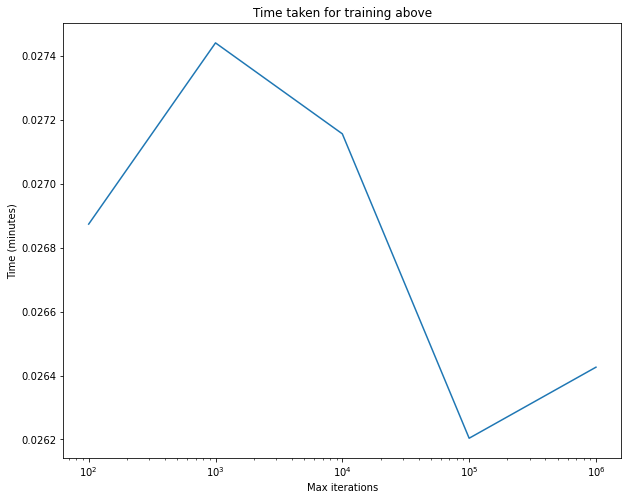

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(max_iters, duration)
ax.set(xscale='log', xlabel='Max iterations', ylabel='Time (minutes)', title='Time taken for training above')